In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# K-Means 2 aproximativo guloso

In [35]:
def greedy_k_means(data, k, type=2):
    def dist(p1, p2):
        """Minkowski distance between two points"""
        p = np.array([p1[0], p1[1]])
        q = np.array([p2[0], p2[1]])
        return np.linalg.norm(p - q, type)
    
    def closest(p, centers,):
        """"Return the index of the closest center to a point"""
        d = [dist(p, c) for c in centers]
        return np.argmin(d), min(d)
    data = data.copy()
    n = data.shape[1] - 1
    centers = []
    centers.append(data.sample().values[0,:-1])
    while len(centers) < k:
        #data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers), axis=1)
        data['closest'] = data.apply(lambda x: closest(x.values[:n], centers)[1], axis=1)
        pos = data['closest'].argmax()
        centers += [data.iloc[pos].values[:n]]
    else:
        data['closest_i'] = data.apply(lambda x: closest(x.values[:n], centers)[0], axis=1)
        data['closest'] = data.apply(lambda x: dist(x.values[:n], centers[int(x['closest_i'])]), axis=1)

    return centers, data['closest'].max(), data['closest_i']

[array([0.55752212, 0.1369863 ]), array([0.26548673, 1.        ]), array([0.03539823, 0.42465753]), array([0.97345133, 0.3869863 ]), array([0.53097345, 0.61643836]), array([0.18584071, 0.02739726])]


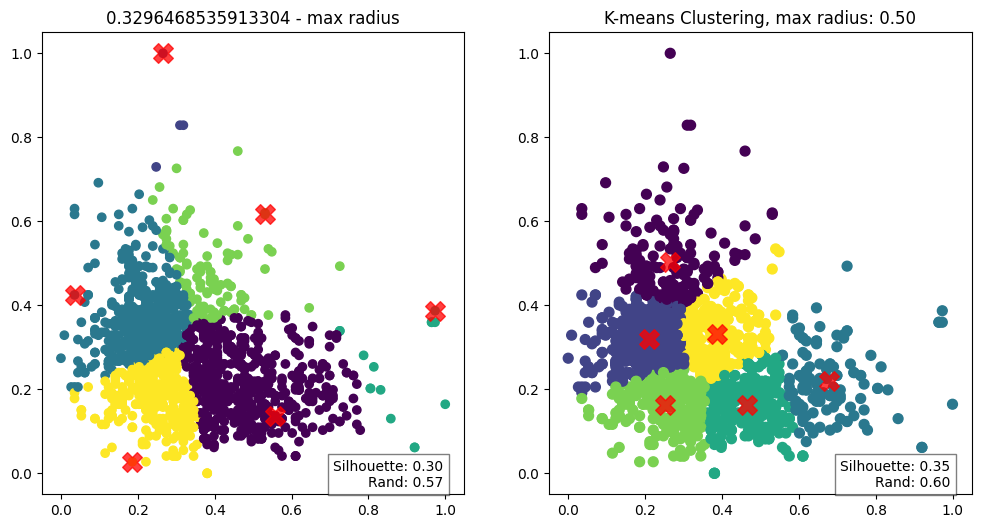

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

# Configurar o tamanho da figura
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df = pd.read_csv(f'reais/1/winequality-red.csv', sep=';')
df = df.rename(columns={'quality': 'label'})
for column in df.columns:
    if column != 'label':
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
df = df[['fixed acidity', 'volatile acidity', 'label']]
# Parte : Algoritmo greedy_k_means
n = len(df['label'].unique())
centers, max_r, predict = greedy_k_means(df, n, 2)
print(centers)
ss = silhouette_score(df.iloc[:,:-1], predict)
rs = rand_score(df['label'], predict)

# Plotar o resultado do greedy_k_means

# Plotar o resultado do greedy_k_means
ax[0].scatter(df.iloc[:,0], df.iloc[:,1], c=predict)
ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
ax[0].set_title(f'{max_r} - max radius')
ax[0].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[0].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))

# Parte 2: K-means do sklearn
X, y = df.iloc[:, :-1], df['label']
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
labels = kmeans.fit_predict(X)
distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values)])

# Imprimir métricas
sil_score = silhouette_score(X.values, labels)
rand_score_value = rand_score(y, labels)

# Plotar o resultado do K-means
ax[1].scatter(X.values[:, 0], X.values[:, 1], c=labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[1].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))
# Configurar título e rótulos
ax[1].set_title(f'K-means Clustering, max radius: {mar_r_sklearn:.2f}')

# Exibir os gráficos
plt.show()

